# EXERCISE 4

A paper published in the Journal of Quality Technology (Cryer e Ryan, 1990, vol.22 no. 3, p. 189) presented the data of a chemical process where the measured variable is a color property. Data are stored in the file `ESE3_es4_dataset.csv`.

1. Identify a model for the measured variable and compute a confidence interval on estimated coefficients. 
2. Compute the prediction for the next process outcome.

## Point 1

Identify a model for the measured variable and compute a confidence interval on estimated coefficients.

> ### Solution
> First, we visually inspect the data. 

    Ex4
0  0.67
1  0.63
2  0.76
3  0.66
4  0.69


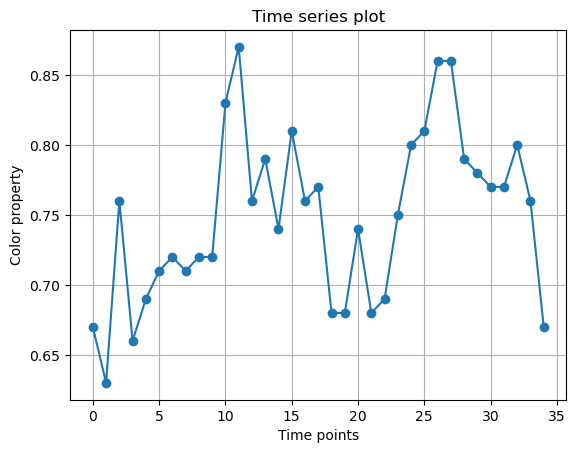

In [1]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

#Import the dataset
data = pd.read_csv('ESE3_es4_dataset.csv')

# Inspect the dataset
print(data.head())

#Time series plot
plt.plot(data, 'o-')
plt.title('Time series plot')
plt.xlabel('Time points')
plt.ylabel('Color property')
plt.grid()
plt.show()

> Now, let's verify randomness: we perform the runs test.

In [2]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['Ex4'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

if pval_runs<0.05:
    print('The null hypothesis is rejected: the process is not random')
else:
    print('The null hypothesis is accepted: the process is random')


Runs test p-value = 0.001
The null hypothesis is rejected: the process is not random


> Alwan defines this kind of process as a «meandering process»: a process with successive observations tending to be close together in value (locally).
> 
> Let's plot autocorrelation and partial autocorrelation functions.

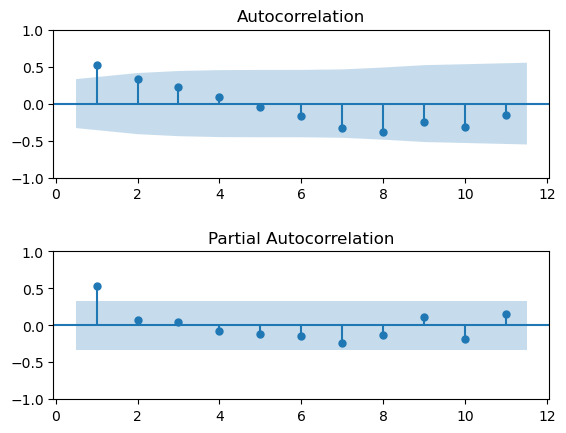

In [3]:
#ACF and PACF
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['Ex4'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['Ex4'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> We can see from the plots that the process seems autocorrelated. Let's test autocorrelation at lag 1 through the Bartlett's test.

In [4]:
from statsmodels.tsa.stattools import acf, pacf

#autocorrelation function
[acf_values, lbq, _] = acf(data, nlags = int(len(data)/3) , qstat=True, fft = False)
#partial autocorrelation function
pacf_value = pacf(data, nlags = int(len(data)/3))

#Bartlett's test at lag n_lag
lag_test = 1
rk=abs(acf_values[lag_test])
print('Test statistic rk= %f' % rk)

#Critical values
alpha = 0.05
z_alpha2=stats.norm.ppf(1-alpha/2)
print('Rejection region starts at %f' % (z_alpha2/np.sqrt(len(data))))


if rk>z_alpha2/np.sqrt(len(data)):
    print('The null hypothesis is rejected')
else: print('The null hypothesis is accepted')

Test statistic rk= 0.528209
Rejection region starts at 0.331294
The null hypothesis is rejected


> The p-value is less than 0.05, so we can reject the null hypothesis of no autocorrelation at lag 1.

> Positive correlation reflects the tendency of observations close in time to be close in value. Let's visualize this using a scatterplot of variable at time $t$ vs. variable at time $(t-1)$.

In [5]:
# Calculate the lag1 from data
data['lag1'] = data['Ex4'].shift(1)

In [6]:
data.head()

,Ex4,lag1
0,0.67,NaN
1,0.63,0.67
2,0.76,0.63
3,0.66,0.76
4,0.69,0.66


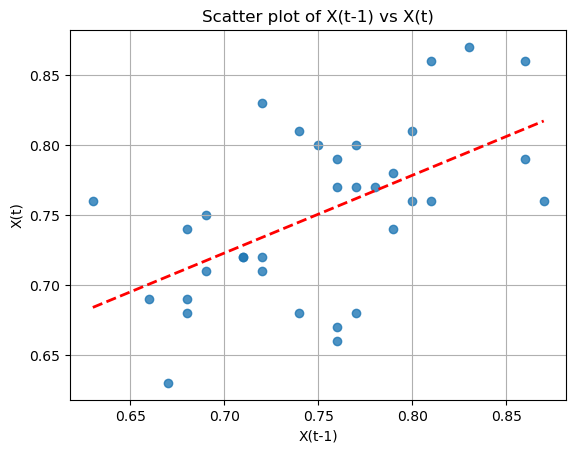

In [7]:
# Create scatterplot with regression line using seaborn and set axis labels
import seaborn as sns
sns.regplot(x='lag1', y='Ex4', data=data, fit_reg=True, ci=None, line_kws={'color': 'red', 'lw': 2, 'ls': '--'})
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.xlabel('X(t-1)')
plt.ylabel('X(t)')
plt.title('Scatter plot of X(t-1) vs X(t)')
plt.grid()

> The most suitable model seems to be AR(1) with positive coefficient (meandering process).

> An AR(1) model can be fitted via linear regression, using *lag1* as regressor.
>
> To do so, we can use the `OLS` function from the `statsmodels` package.
> The function `OLS` takes as input:
> - The time series, `y` (i.e., the variable to be modeled)
> - The regressors, `x` (i.e., the lag1 variable)
>
> After defining the model, we can fit it using the method `fit()`.

In [8]:
#calculate a regression model with constant and lag1
import statsmodels.api as sm

x = data['lag1'][1:]


In [9]:

# Add a constant to the model (it is equivalent to adding a column of ones to the data).
x = sm.add_constant(data['lag1'][1:]) 


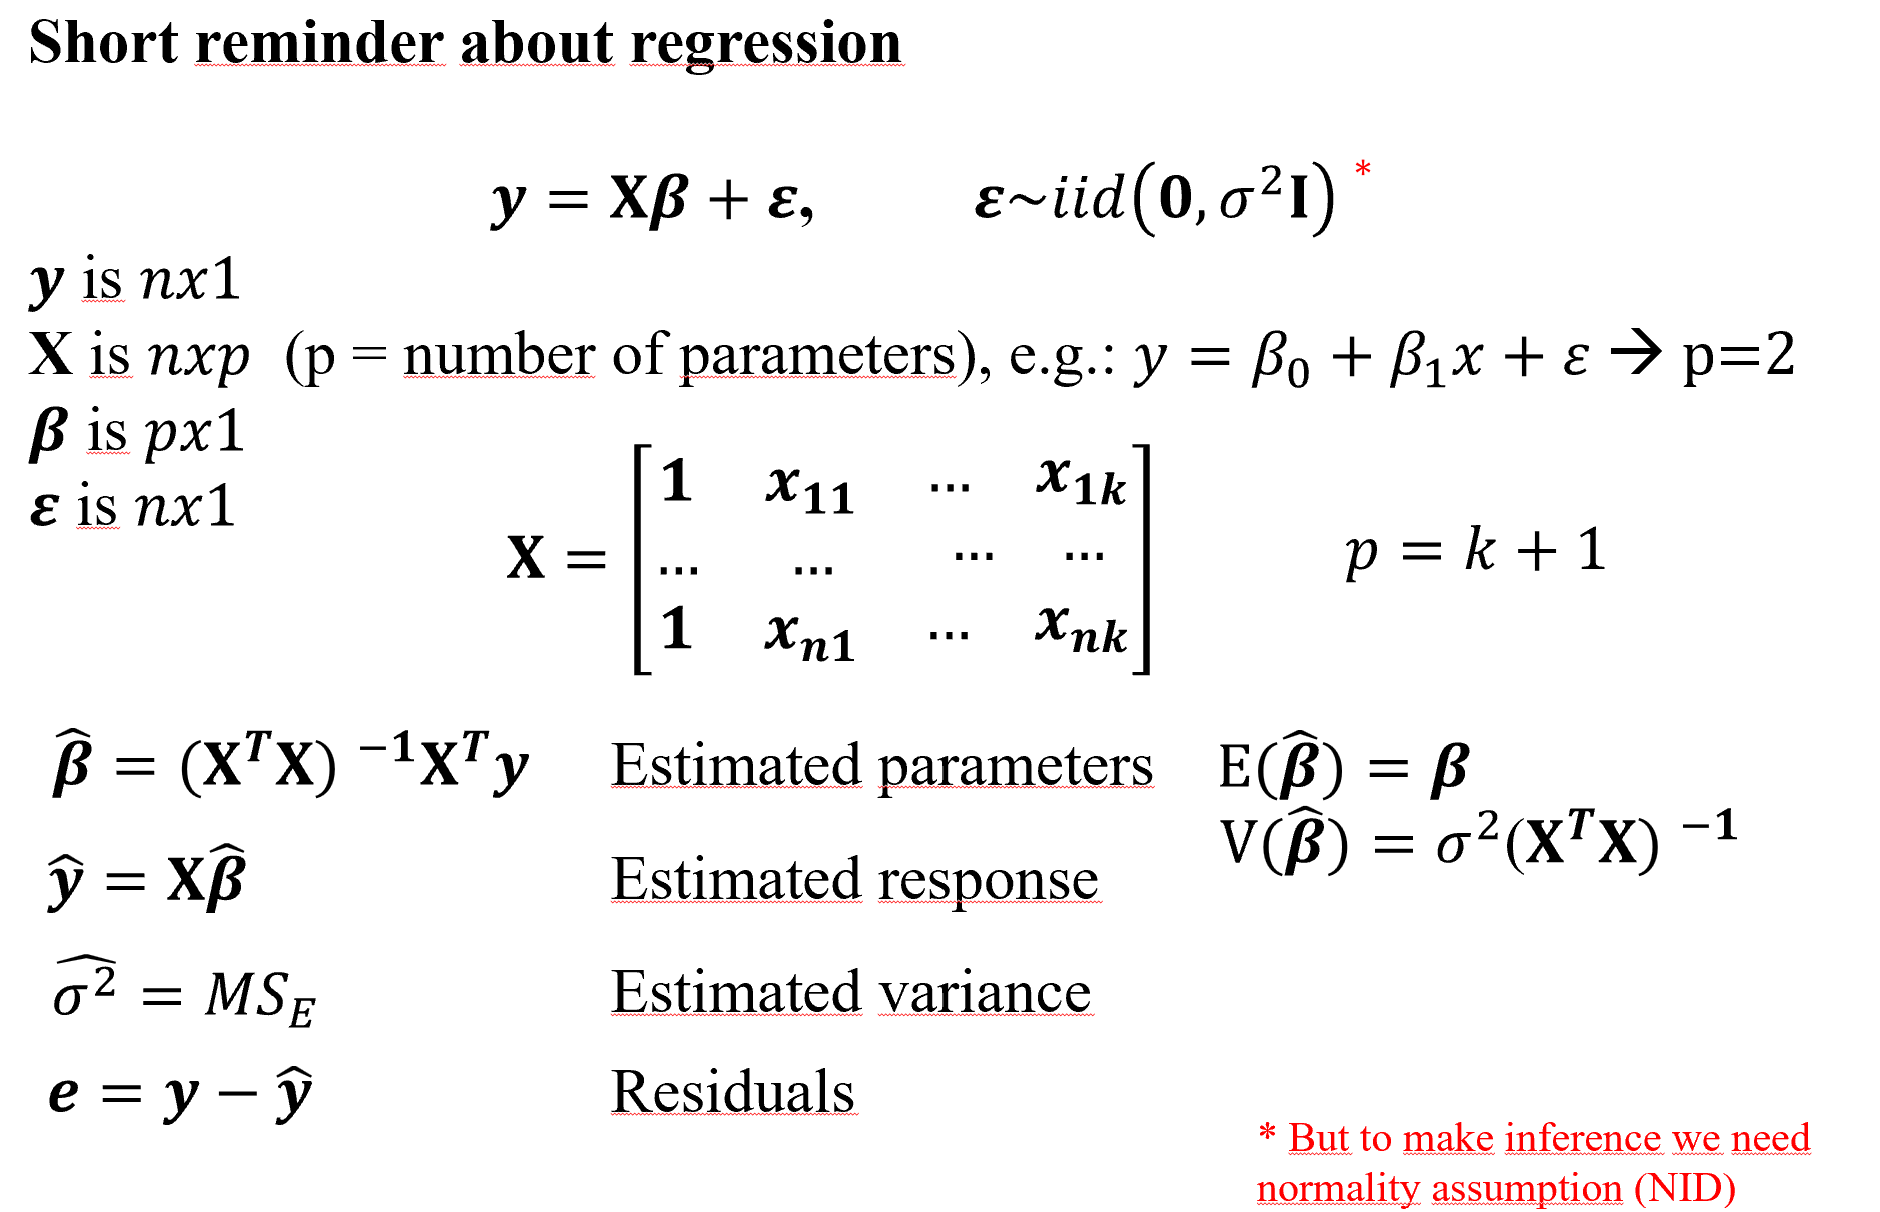

In [10]:

y = data['Ex4'][1:]
model = sm.OLS(y, x).fit()

In [11]:
# Print out the statistics
import qda
qda.summary(model)


REGRESSION EQUATION
-------------------
Ex4 =  + 0.334 const + 0.555 lag1

COEFFICIENTS
------------
 Term   Coef  SE Coef  T-Value  P-Value
const 0.3343   0.1108   3.0171   0.0050
 lag1 0.5549   0.1471   3.7734   0.0007

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
0.0509 0.3079     0.2863

ANALYSIS OF VARIANCE
---------------------
    Source   DF  Adj SS  Adj MS  F-Value  P-Value
Regression  1.0  0.0369  0.0369  14.2383   0.0007
     const  1.0  0.0236  0.0236   9.1029   0.0050
      lag1  1.0  0.0369  0.0369  14.2383   0.0007
     Error 32.0  0.0829  0.0026      NaN      NaN
     Total 33.0  0.1198     NaN      NaN      NaN


> ### Test for significance of regression
> - $ H_{0} : \beta_{1} = \beta_{2}  = \beta_{k} =0 $
> - $ H_{1}: \exists \beta_{i} \neq 0 $
>
> Partition of the variance: $ SS_{TOT} = SS_{REG} + SS_{E} $
>
> Degrees of freedom: $ (n-1) = (p-1) + (n-p) $
>
> Definition of the sum of squares:
>
> - $ SS_{TOT} = \sum_{i=1}^n (y_{i}- \bar{y_{i}})^2 $
>
> - $ SS_{REG} = \sum_{i=1}^n (\hat{y_{i}} - \bar{y_{i}})^2 $
>
> - $ SS_{E} = \sum_{i=1}^n (y_{i}- \hat{y_{i}})^2 $
>
> If $H_0$ is true:
> - $ \frac{SS_{REG}}{\sigma^2} \sim \chi^2_{p-1} $
> - $ \frac{SS_{E}}{\sigma^2} \sim \chi^2_{n-p} $
>
> then:
> $$ F_0 = \frac{SS_{REG}/(p-1)}{SS_{E}/(n-p)} = \frac{MS_{REG}}{MS_{E}} \sim F_{p-1,n-p} $$
>
> Reject $H_0$ if: $F_0 > F_{\alpha,p-1,n-p} $
>
> The F-statistic and the corresponding p-value is displayed in the **ANALYSIS OF VARIANCE** table. 

> ### Test for individual coefficients
> - $ H_{0} : \beta_{i} = 0 $
> - $ H_{1} : \beta_{i} \neq 0 $
>
> Test statistic: $T_0 = \frac{\hat{\beta_{i}}}{se(\hat{\beta_{i}})} = \frac{\hat{\beta_{i}}}{\sqrt{\hat{\sigma^2} C_{i}}} $
>
> Where $C_{i}$ is the $i$-th diagonal element of the $(\mathbf{X}^T \mathbf{X})^{-1}$ matrix.
>
> If $H_0$ is true: $T_0 \sim t_{n-p}$
>
> Reject $H_0$ if: $|T_0| > t_{\alpha/2,n-p} $
>
> The t-statistic and the corresponding p-value is displayed in the **COEFFICIENTS** table.



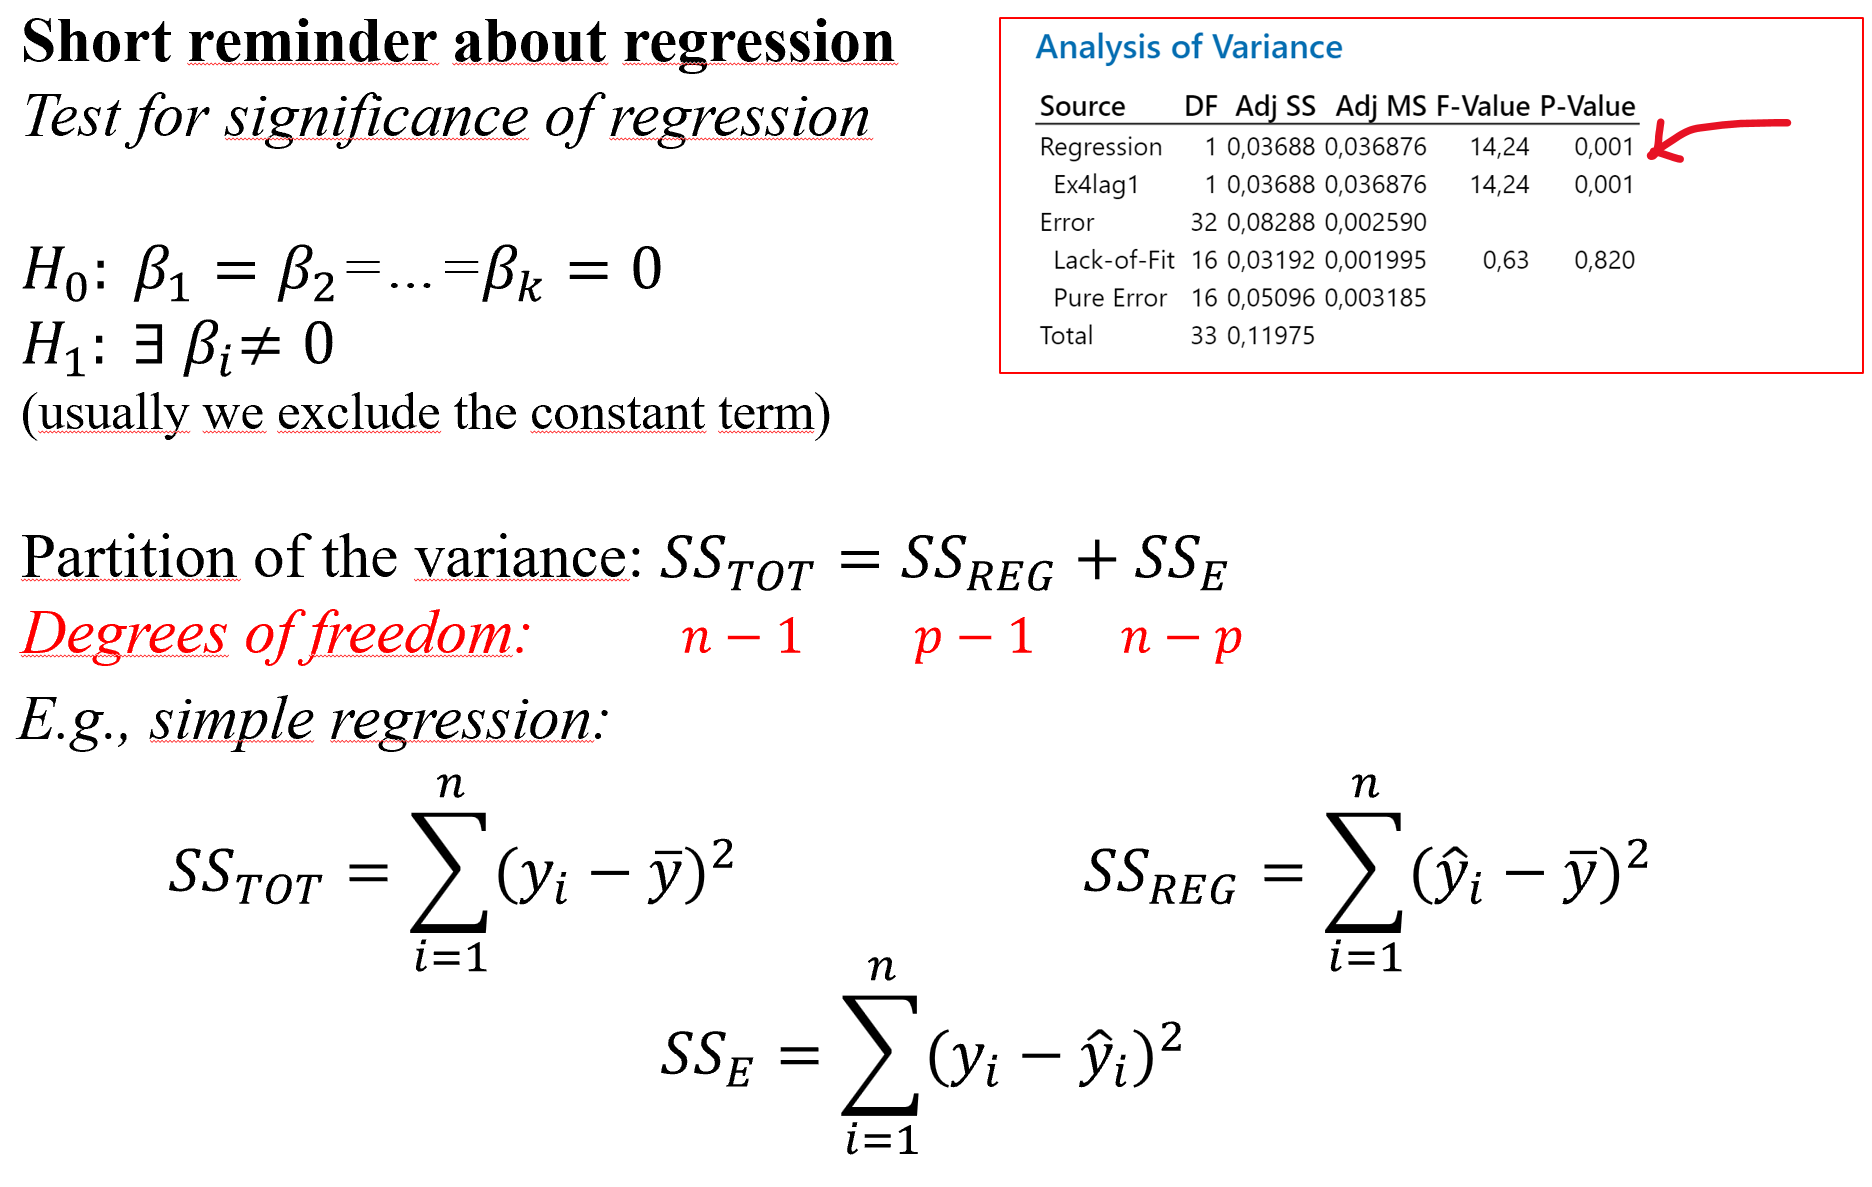

> The AR(1) model is: $ X_t = 0.334 + 0.555 \cdot X_{t-1} + e_t  $

> Check on residuals
>
>$ \varepsilon \sim NID  (\mathbf{0}, \sigma^2 \mathbf{I}) $
> 
>Normal and independently distributed

> Let's check residuals. To accept the model, we also need to verify the assumption that residuals are normal and independently distributed.

> First, we check normality of residuals. 

Shapiro-Wilk test p-value on the residuals = 0.579


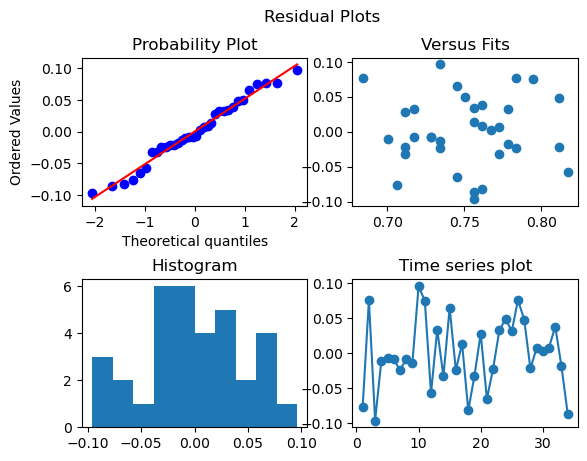

In [12]:
#NORMALITY OF RESIDUALS

fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(model.fittedvalues, model.resid)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(model.resid)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')

_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

> - The normal probability plot (top left) shows a normal distribution of the residuals. 
> - The histogram (bottom left) confirms normality. 
> - On top right, residuals versus fits are shown. 
> - The bottom right panel shows the time series plot of the residuals. 
>
> Based on the Shapiro-Wilk test, the assumption on normality of residuals is accepted.

Runs test p-value on the residuals = 0.742


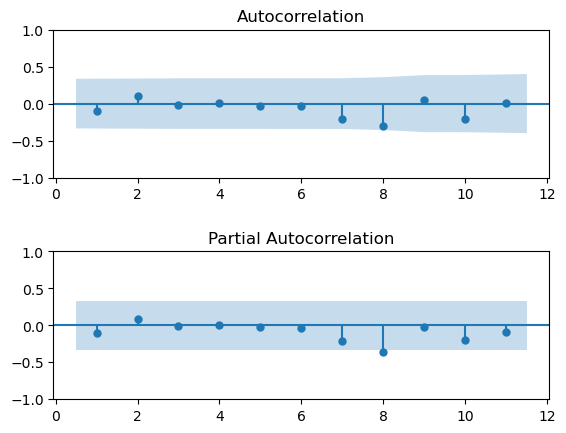

In [13]:
#RANDOMNESS OF FESIDUALS
_, pval_runs_res = runstest_1samp(model.resid, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> Residuals do not show autocorrelation. Assumption on randomness of residuals is accepted.

> Let's compute the confidence interval on the AR(1) coefficient

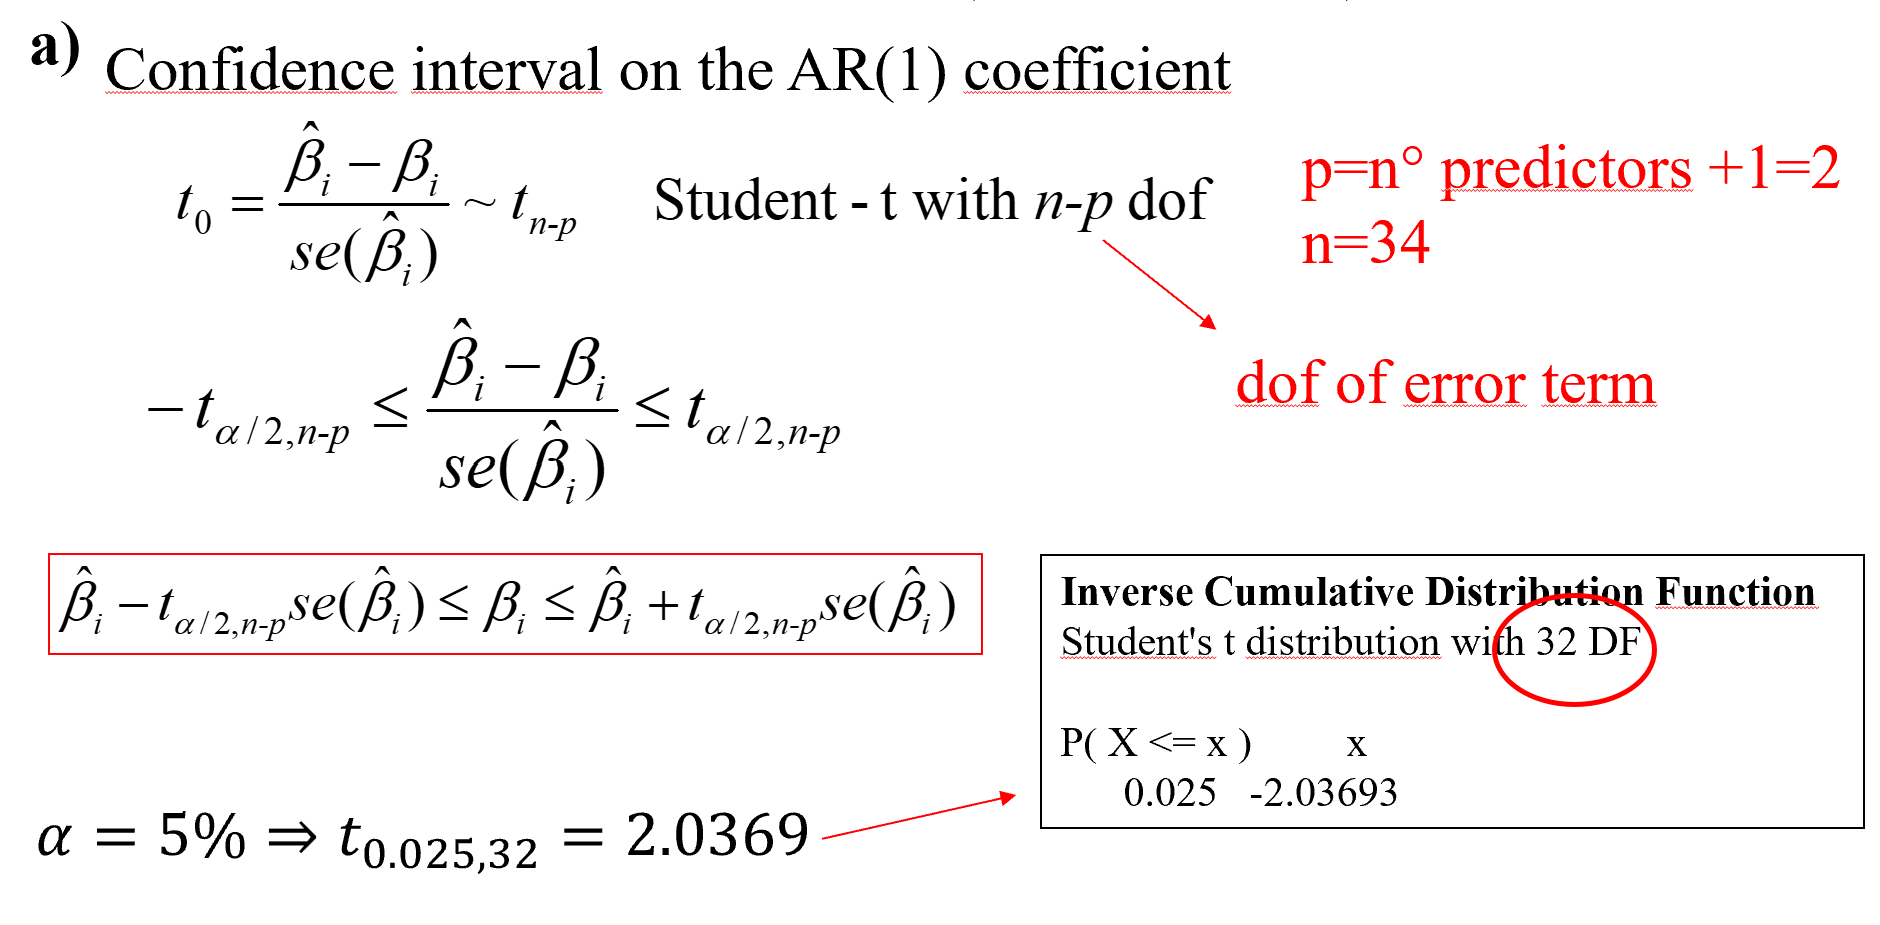

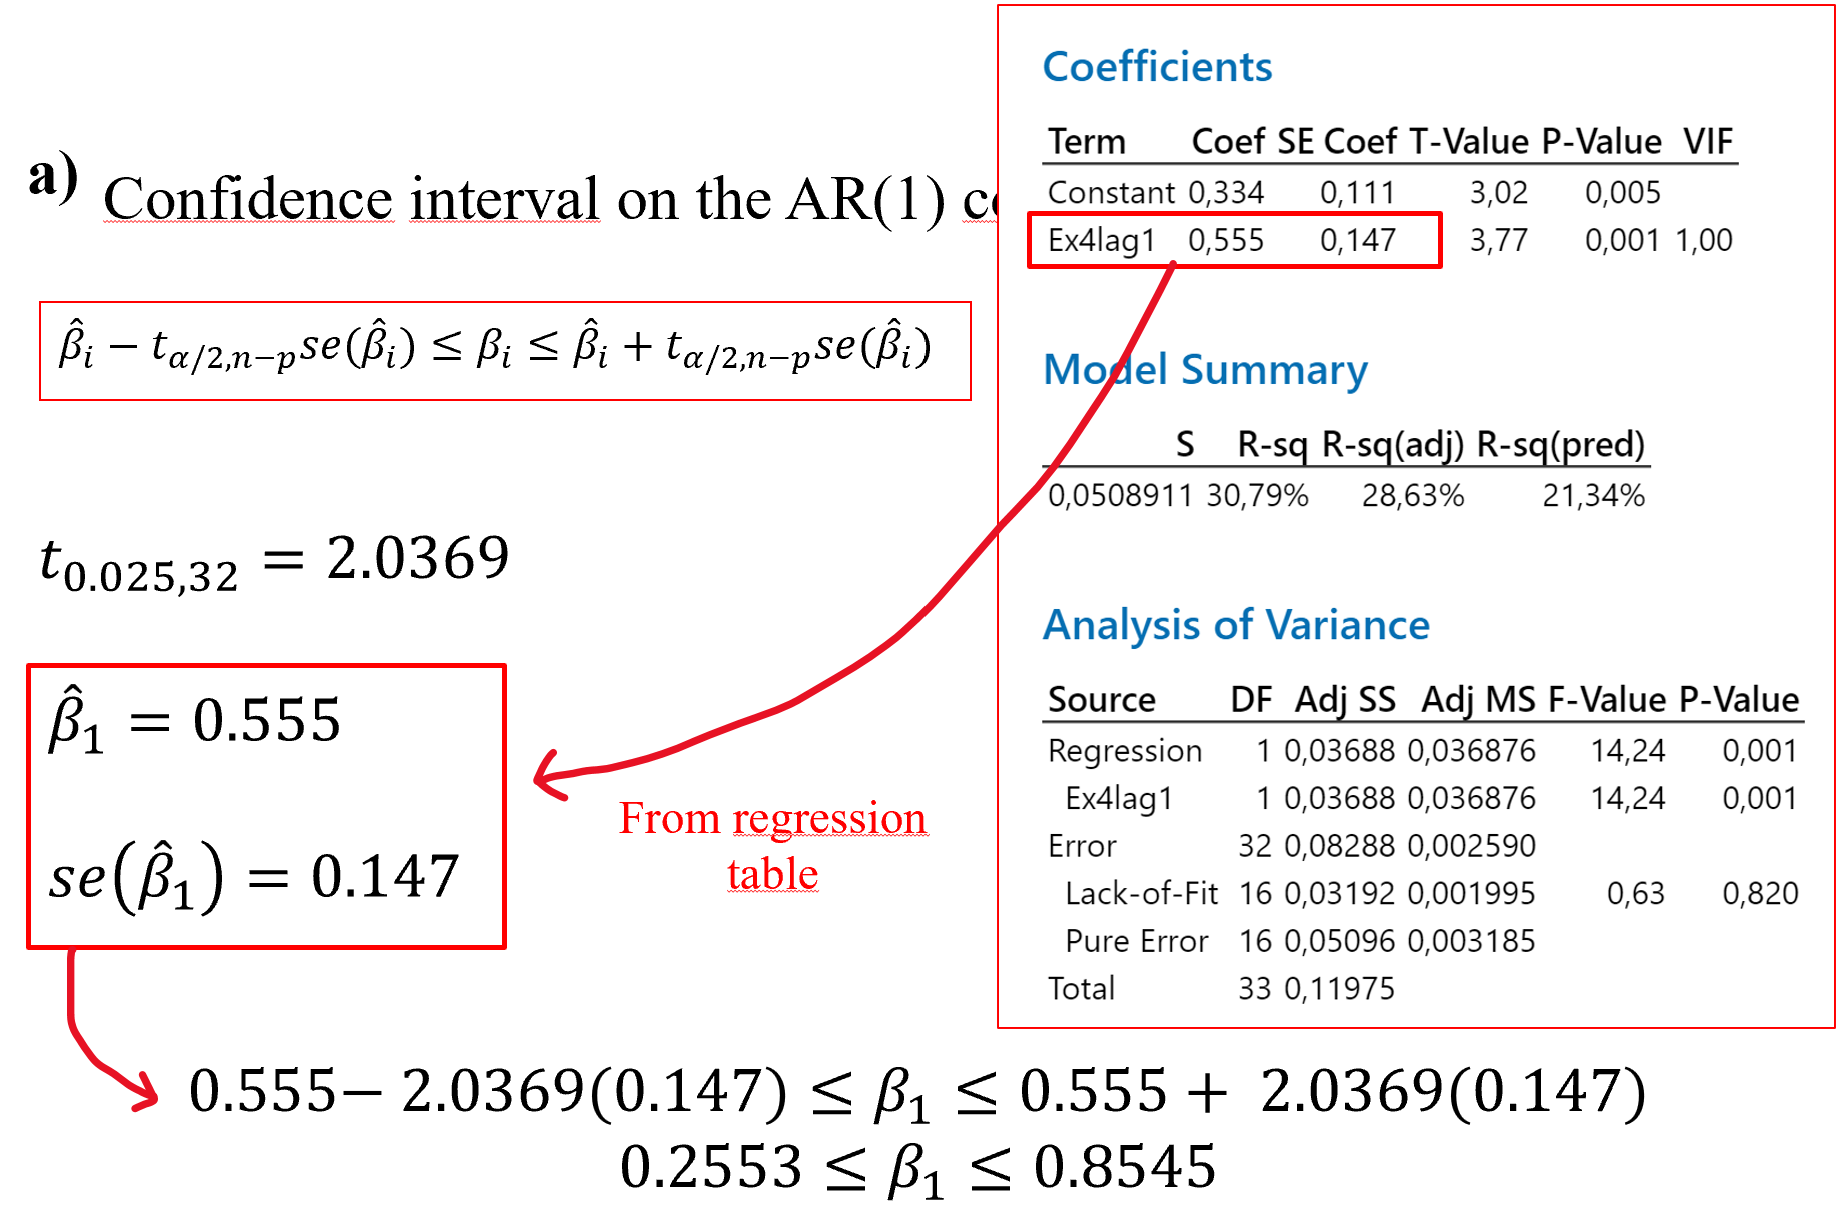

You can access the values of the estimated coefficients and their standard errors from the  `RegressionResult` object that is the output of the `fit()` method.

In [14]:
# The RegressionResult object was stored in the variable model
# Get the estimated coefficient
beta1 = model.params['lag1']
print('The estimated coefficient beta1 is %.3f' % beta1)

se_beta1 = model.bse['lag1']
print('The standard error of the estimated coefficient beta1 is %.3f' % se_beta1)

alpha = 0.05
n = len(data)
t_alpha2 = stats.t.ppf(1-alpha/2, n-2)

CI_beta1 = [beta1 - t_alpha2*se_beta1, beta1 + t_alpha2*se_beta1]

print('The confidence interval for beta1 is [%.3f, %.3f]' % (CI_beta1[0], CI_beta1[1]))

The estimated coefficient beta1 is 0.555
The standard error of the estimated coefficient beta1 is 0.147
The confidence interval for beta1 is [0.256, 0.854]


> Alternatively, you can use the `conf_int()` method to compute the confidence interval on the coefficients of the model for any specified value of alpha.

In [15]:
# Calculate the confidence interval
CI_beta1 = model.conf_int(alpha=0.05).loc['lag1']
print('The confidence interval for beta1 is [%.3f, %.3f]' % (CI_beta1[0], CI_beta1[1]))

The confidence interval for beta1 is [0.255, 0.854]


## Point 2

Compute the prediction for the next process outcome. 

First, we plot the data and the fitted values of the AR(1) model

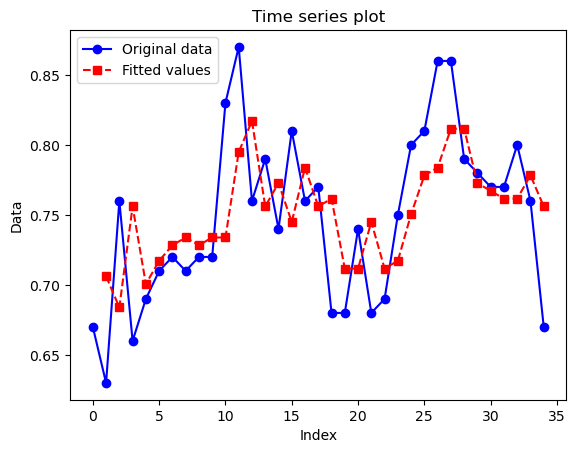

In [16]:
# plot prediction interval
plt.plot(data['Ex4'], 'o-', color='blue', label='Original data')
plt.plot(model.fittedvalues, 's--', color='red', label='Fitted values')
plt.title('Time series plot')
plt.xlabel('Index')
plt.ylabel('Data')
plt.legend()
plt.show()

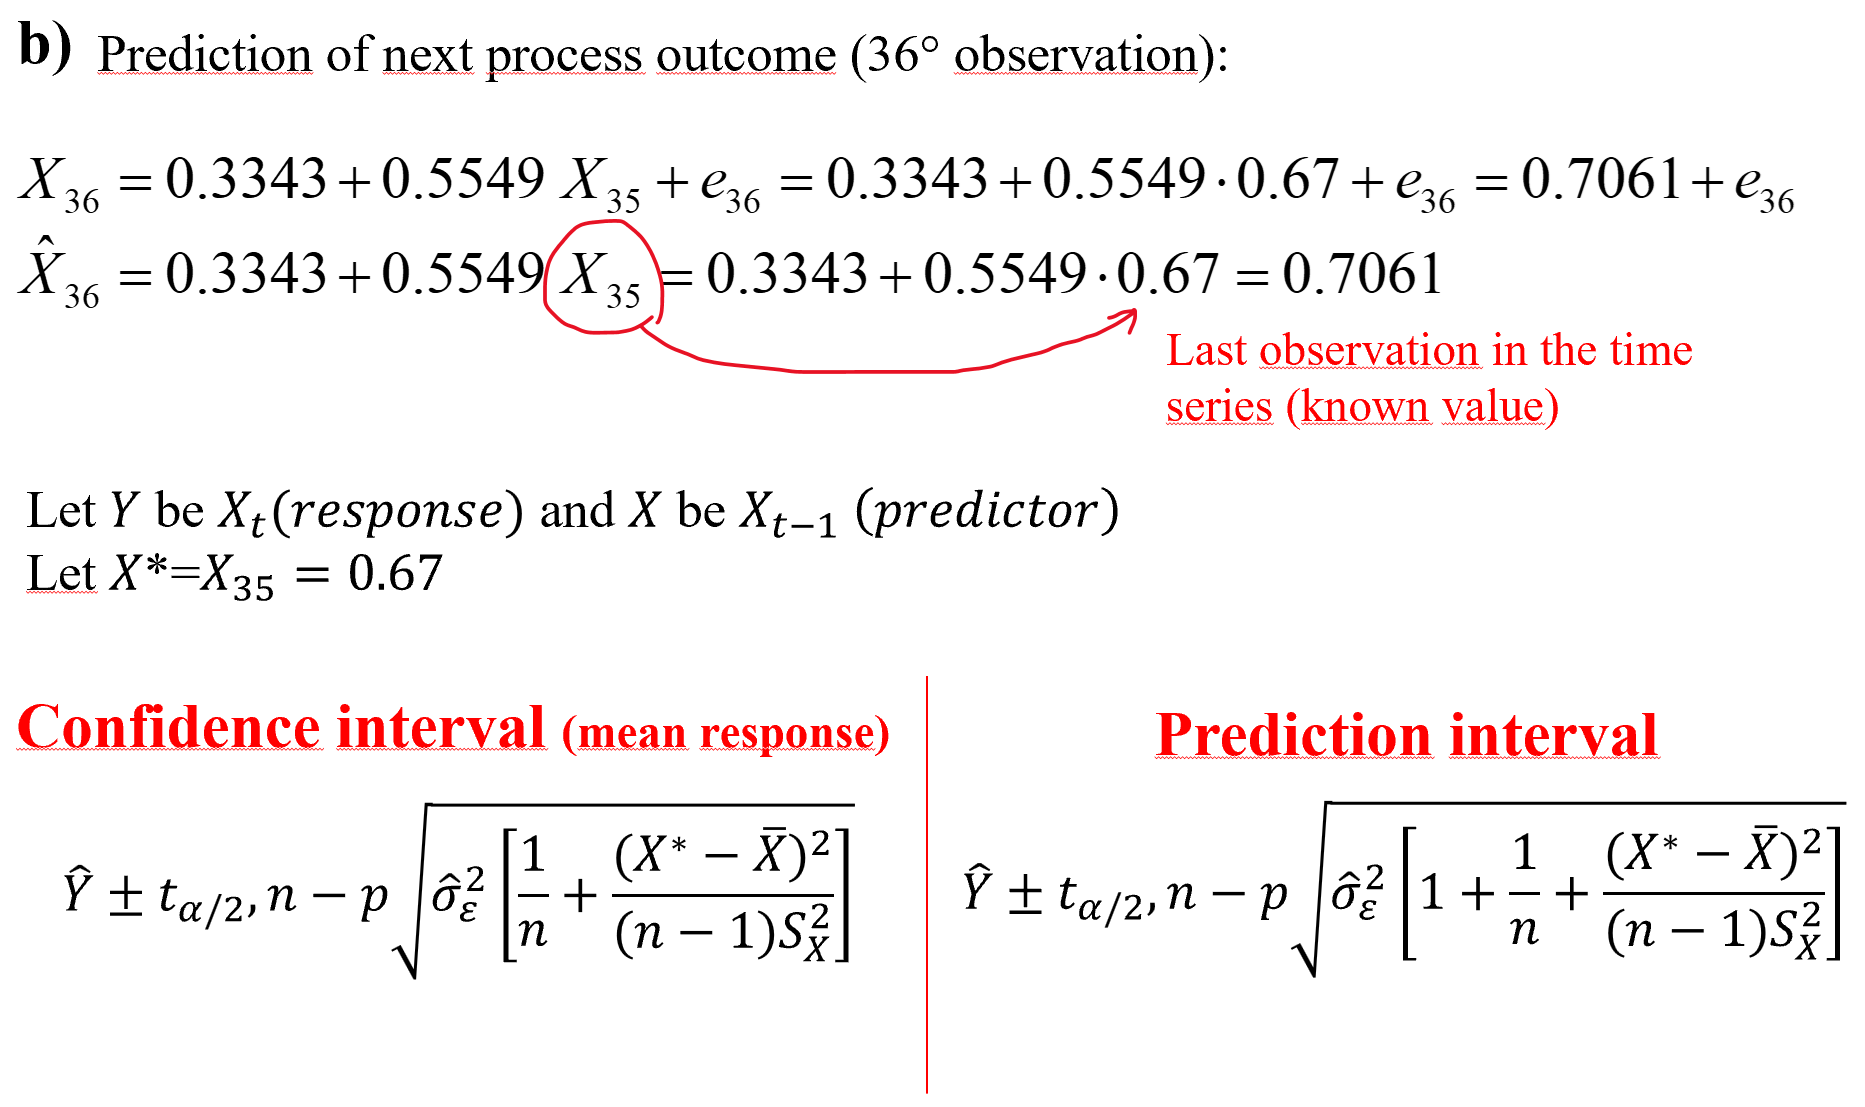

> Let's compute the prediction of the next process outcome (36th observation)

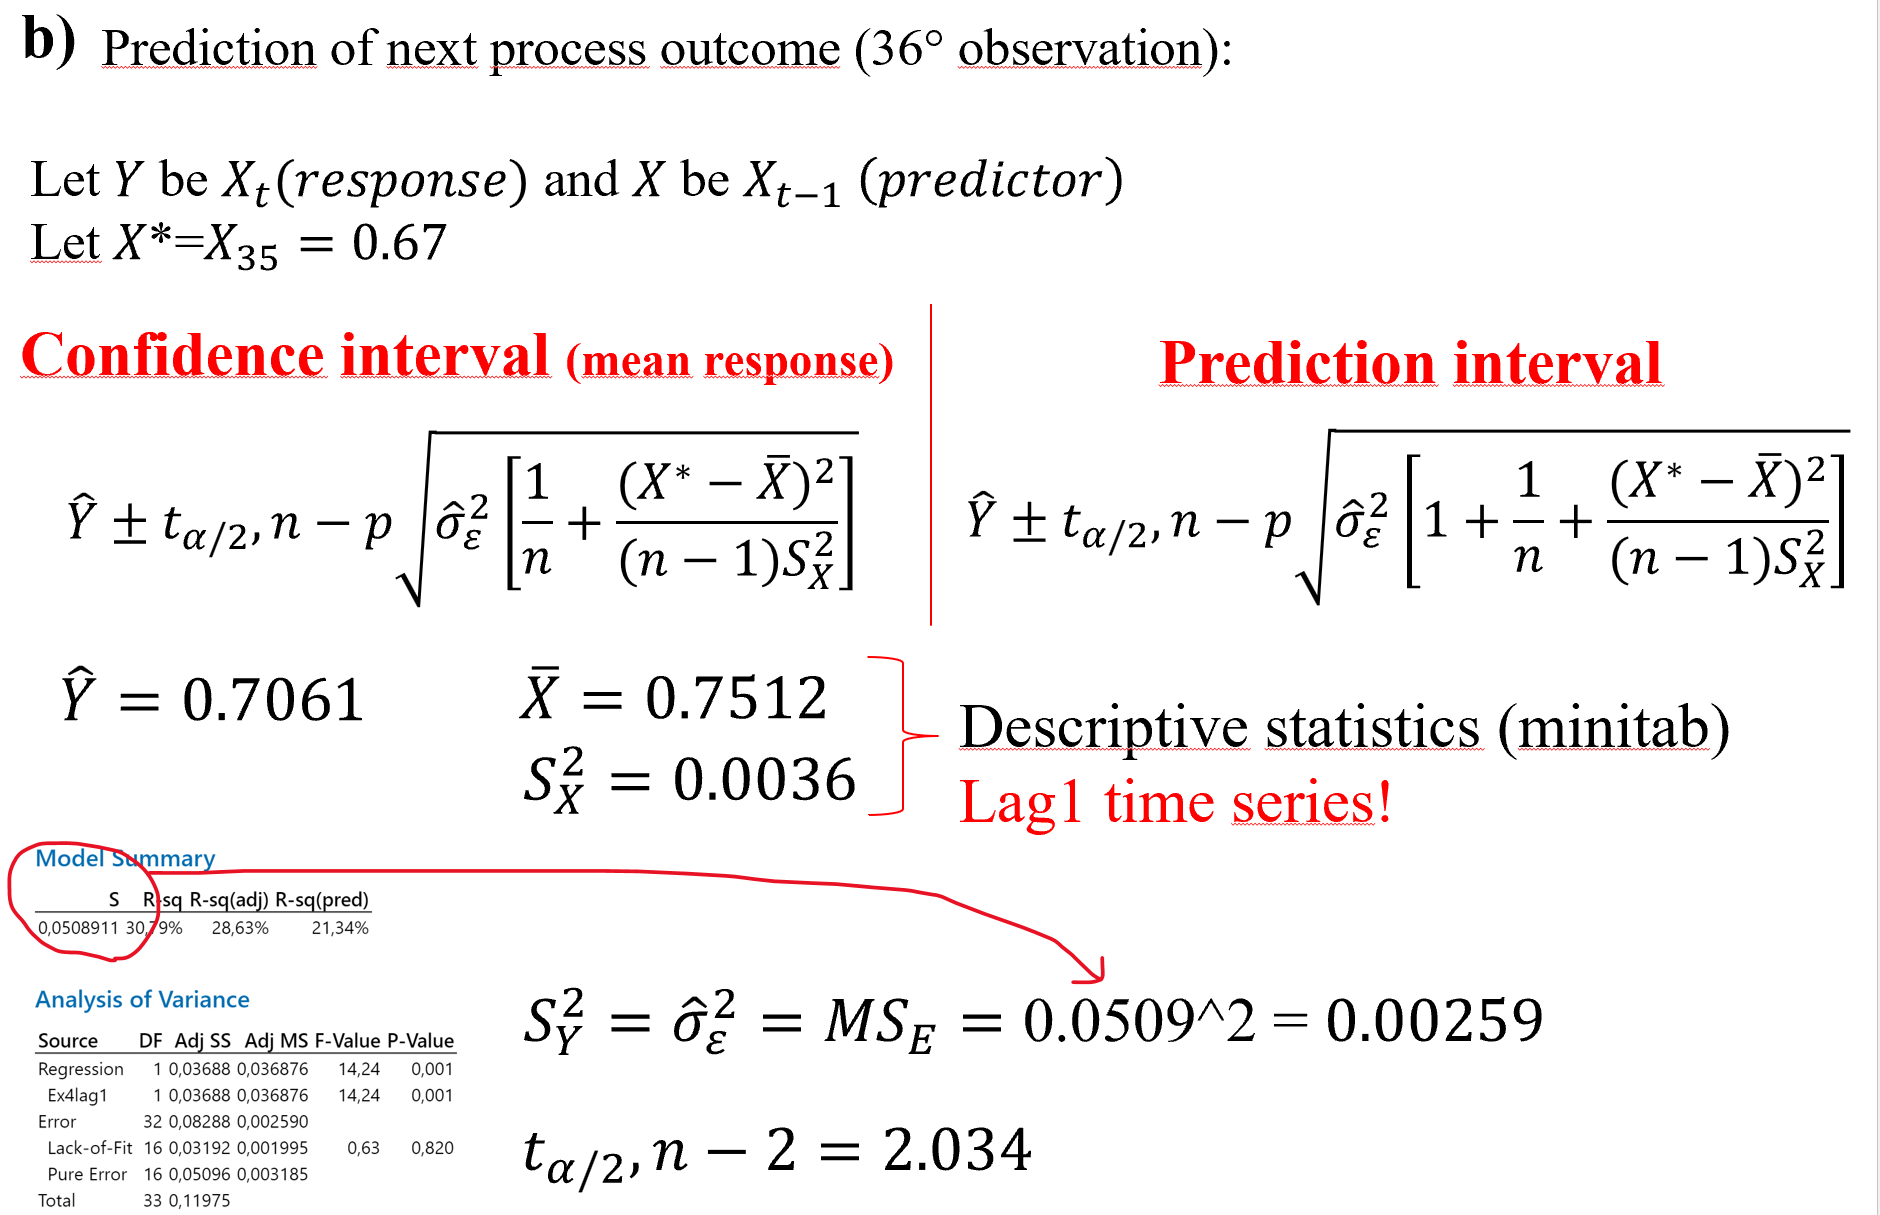

In [17]:
Xbar = data['lag1'].mean()          # sample mean of the regressor
S2_X = data['lag1'].var()           # sample variance of the regressor

p = len(model.model.exog_names)     # number of regressors
S2_Y = np.var(model.resid, ddof=p)  # sample variance of residuals

alpha = 0.05
t_alpha2 = stats.t.ppf(1-alpha/2, n-2)

In [18]:
#predict future outcomes using the regression model
last_lag = data['Ex4'].iloc[-1]
print('X_35 = %.3f' % last_lag)

#predict the next value
Yhat = model.predict([1,last_lag])
print('Next process outcome = %.3f' % Yhat)

X_35 = 0.670
Next process outcome = 0.706


In [19]:
# Calculate the confidence interval
CI = [Yhat - t_alpha2*np.sqrt(S2_Y*(1/n + ((last_lag - Xbar)**2)/((n-1)*S2_X))),
        Yhat + t_alpha2*np.sqrt(S2_Y*(1/n + ((last_lag - Xbar)**2)/((n-1)*S2_X)))]
print('The confidence interval for the mean response is [%.3f, %.3f]' % (CI[0], CI[1]))

The confidence interval for the next value is [0.676, 0.736]


In [20]:
# Calculate the PREDICTION interval
PI = [Yhat - t_alpha2*np.sqrt(S2_Y*(1 + 1/n + ((last_lag - Xbar)**2)/((n-1)*S2_X))),
        Yhat + t_alpha2*np.sqrt(S2_Y*(1 + 1/n + ((last_lag - Xbar)**2)/((n-1)*S2_X)))]

print('The prediction interval for the next value is [%.5f, %.5f]' % (PI[0], PI[1]))

The confidence interval for the next value is [0.59843, 0.81383]


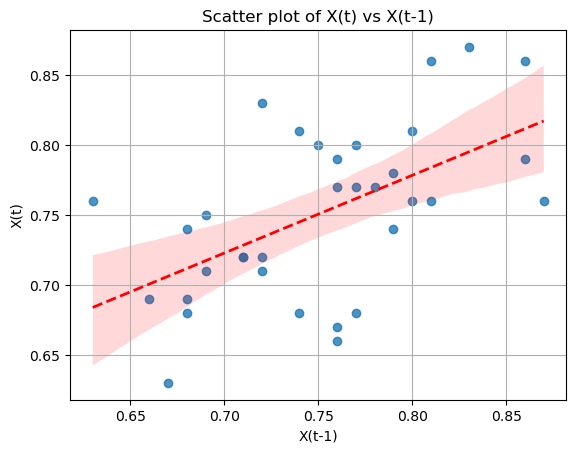

In [21]:
sns.regplot(x='lag1', y='Ex4', data=data, fit_reg=True, ci=95, line_kws={'color': 'red', 'lw': 2, 'ls': '--'})
plt.title('Scatter plot of X(t) vs X(t-1)')
plt.xlabel('X(t-1)')
plt.ylabel('X(t)')
plt.grid()

Alternatively, you can use the `get_prediction()` method to compute the prediction for the next process outcome and the associated confidence and prediction intervals.

In [22]:
# compute the prediction interval
prediction_df = model.get_prediction([1,last_lag]).summary_frame(alpha=0.05)
print(prediction_df)

     mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  0.7061   0.0148          0.676         0.7363        0.5982        0.8141


To visualize the prediction interval, you can evaluate the bounds across the range of the time series using the `get_prediction()` method.

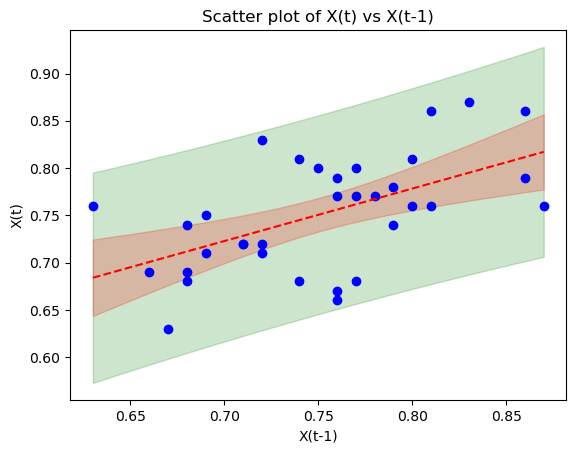

In [23]:
# get the range of values for the regressor
x_range = np.linspace(data['lag1'].min(), data['lag1'].max(), 100)

# add a constant to the regressor
x_range = sm.add_constant(x_range)

# get the prediction interval for each value of the regressor
prediction_df = model.get_prediction(x_range).summary_frame(alpha=0.05)

# plot the data and the intervals
plt.plot(data['lag1'], data['Ex4'], 'o', color='blue', label='Original data')
plt.plot(x_range[:,1], prediction_df['mean'], '--', color='red', label='Fitted values')
plt.fill_between(x_range[:,1], prediction_df['obs_ci_lower'], prediction_df['obs_ci_upper'], color='green', alpha=0.2)
plt.fill_between(x_range[:,1], prediction_df['mean_ci_lower'], prediction_df['mean_ci_upper'], color='red', alpha=0.2)
plt.title('Scatter plot of X(t) vs X(t-1)')
plt.xlabel('X(t-1)')
plt.ylabel('X(t)')
plt.show()